In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import cv2
import sys
import math
from pathlib import Path
from compress_pickle import dump, load

PIPELINE_ROOT = Path('./').resolve().parent.parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())
print(PIPELINE_ROOT)

from src.library.utilities.utilities_process import read_image, write_image
from src.library.cell_labeling.cell_utilities import calculate_correlation_and_energy, find_connected_segments, load_image, subtract_blurred_image


/home/eddyod/programming/pipeline


In [16]:
def show_image(img, increaser=1, _title="", fsize=[15,15]):
    plt.figure(figsize=[15,15])
    plt.imshow(img * increaser, cmap="gray")
    plt.title(_title,fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()

def collect_positives(uimg, startr, startc, tile_width, tile_height):
    img=np.copy(uimg)
    positives=[]
    radius = 80
    a=int(radius/2)
    color = (65000)
    min_row,min_col = startr, startc
    for index,r in df.iterrows():
        col = int(round(r['x'])-min_col)
        row = int(round(r['y'])-min_row)
        if (col<0) or (col>tile_width) or (row<0) or (row>tile_height):
            continue
        img=cv2.circle(img, (int(col), int(row)), radius, color, 20)
        I=uimg[row-a:row+a,col-a:col+a]
        if I.shape==(radius,radius):
            positives.append((col,row,I))

    return img,positives

In [3]:
animal = 'DK184'
section = 0
channel = 3
prep_path = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'

In [4]:
tif = str(section).zfill(3) + ".tif"
filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
full_img = read_image(filepath)
full_img.shape

(25000, 30000)

In [ ]:
resize = True
if resize:
    filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
    startr = 0
    endr = 25000
    startc = 35000
    endc = 65000
    img = full_img[startr:endr, startc:endc]
    print(img.shape)
    write_image(filepath, img)

In [30]:
dfpath = os.path.join(prep_path, 'cell_labels', 'all_predictions.csv')
df = pd.read_csv(dfpath)
df = df.loc[df['section'] == section]
df = df.sort_values(['section', 'y', 'x'])
df.head()

,x,y,section
115,26346.0,5718.0,0
110,25314.0,5890.0,0
122,27470.0,5908.0,0
64,21286.0,6135.0,0
61,20817.0,6322.0,0


In [7]:
count = len(df.index)
print(f'{count=}')
if count > 100:
    lower = count // 4
    upper = lower + 100
    print(lower, upper)
    df = df[lower:upper]
print(len(df.index))

count=157
39 139
100


In [31]:
#startc = int(round(min(df['x']), -3)) - 1000
#startr = int(round(min(df['y']), -3)) - 1000
#endc = math.ceil(max(df['x'])) + 100
#endr = math.ceil(max(df['y'])) + 100
# manually set to ROI
startr = 0
endr = startr + full_img.shape[0]
startc = 0
endc = startc + full_img.shape[1]
print(startr, endr, startc, endc)

0 25000 0 30000


In [32]:
tile_width = endc - startc
tile_height = endr - startr
img = full_img[startr:endr, startc:endc]
print(f'{startr}:{endr}, {startc}:{endc}')
print(img.shape)
print(f'{tile_width=} {tile_height=}')
#img.shape # (6800, 30000)

0:25000, 0:30000
(25000, 30000)
tile_width=30000 tile_height=25000


In [33]:
annotated_img, positives = collect_positives(full_img, startr, startc, tile_width, tile_height)
print(len(positives))

157


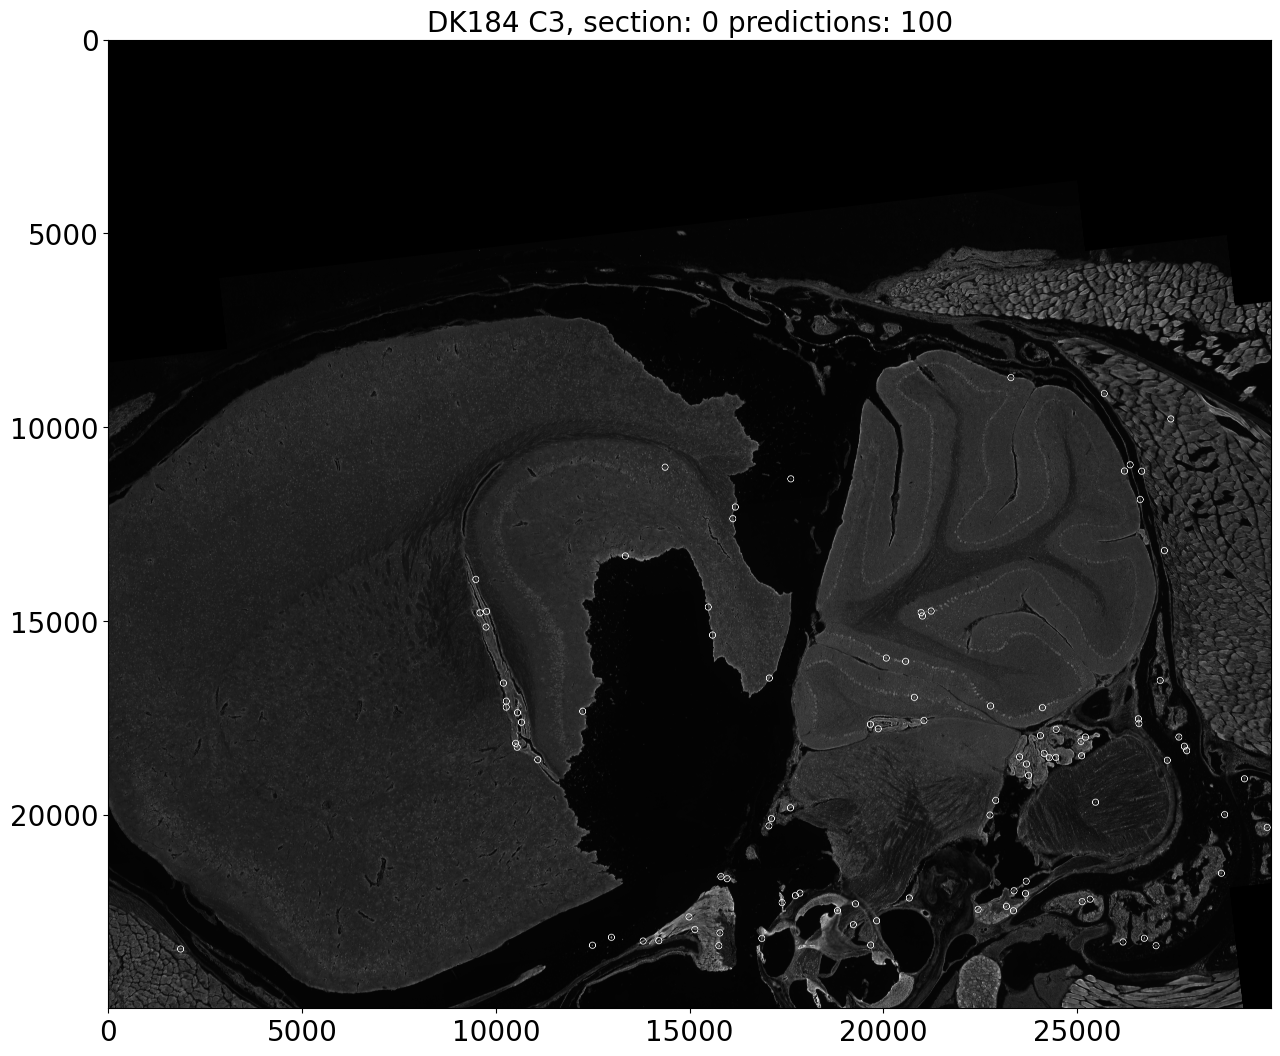

In [13]:
#vimg=annotated_img[in_row_min:in_row_max, in_col_min: in_col_max]
increaser = 5
show_image(annotated_img, increaser=increaser,_title=f'{animal} C{channel}, section: {section} predictions: {len(positives)}')

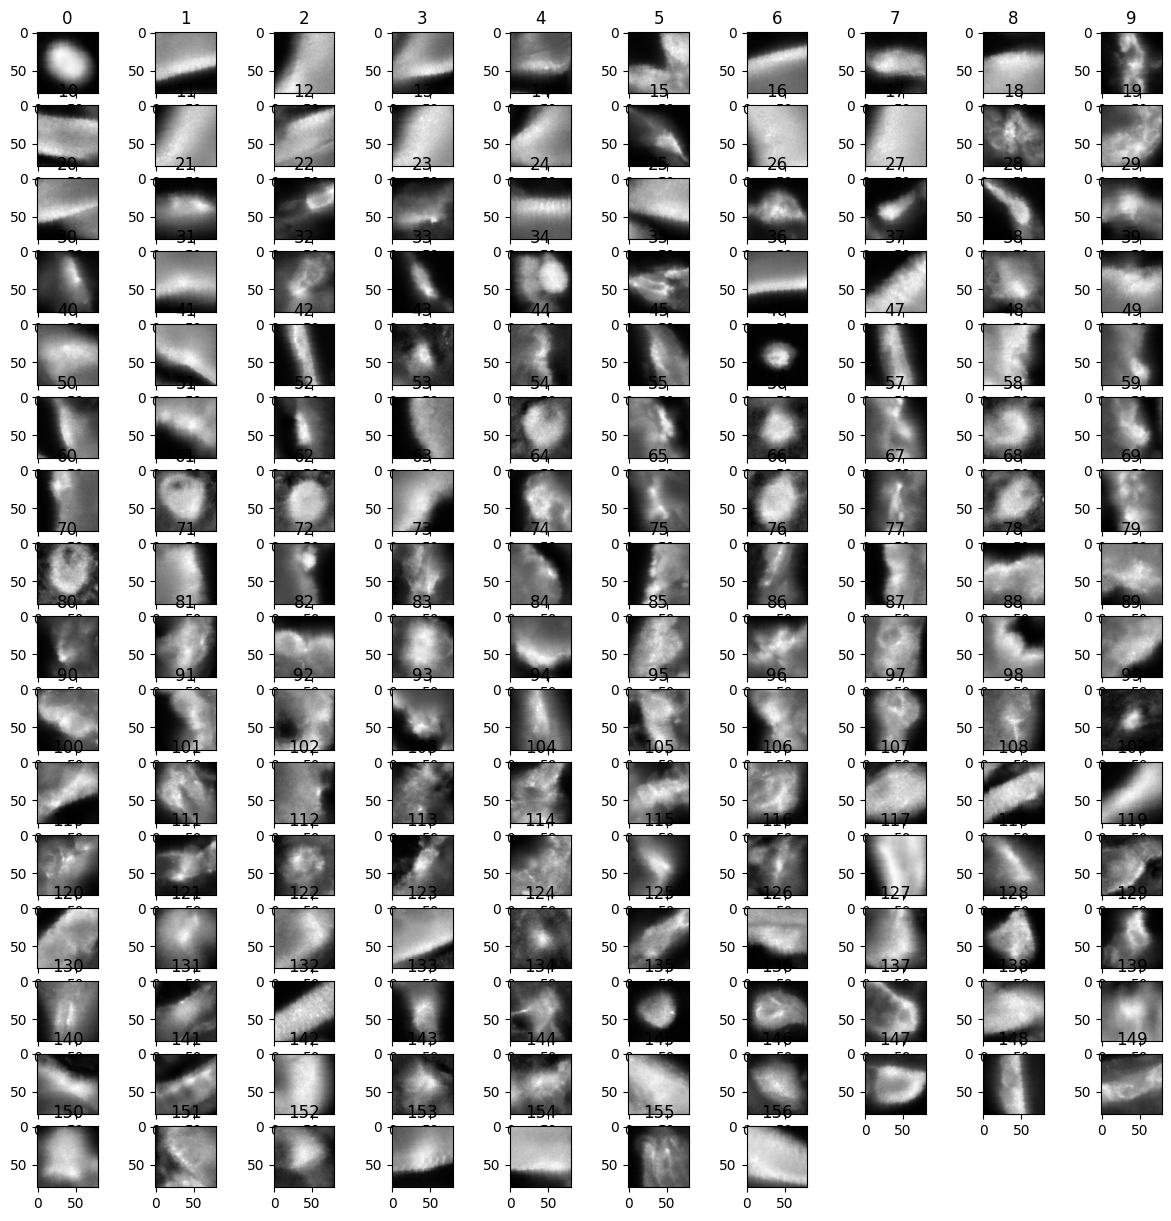

In [34]:
plt.figure(figsize=[15,15])
end = min(157, len(positives))
for i in range(len(positives[0:end])):
    plt.subplot(16,10,i+1)
    plt.title(i)
    plt.imshow(positives[i][2], cmap="gray")
plt.show()

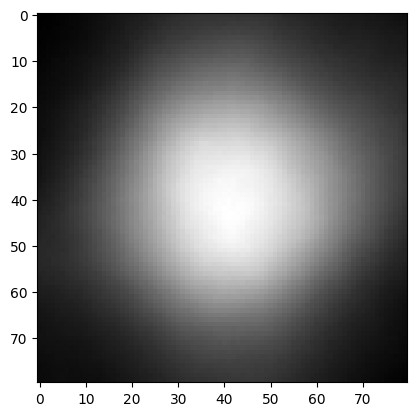

before: mean=3493.78 std=1065.65
after: mean= 0.00 std= 1.00


In [35]:
S=np.stack([I for (x,y,I)in positives])
S.shape

Mean=np.mean(S,axis=0)
Mean.shape

plt.imshow(Mean, cmap="gray")
plt.show()

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
print('before: mean=%5.2f std=%5.2f'%(_mean,_std))

Mean = (Mean-_mean)/_std

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
print('after: mean=%5.2f std=%5.2f'%(_mean,_std))

import pickle as pk
with open('mean.pkl','wb') as pkl_file:
    pk.dump({'Mean':Mean},pkl_file)

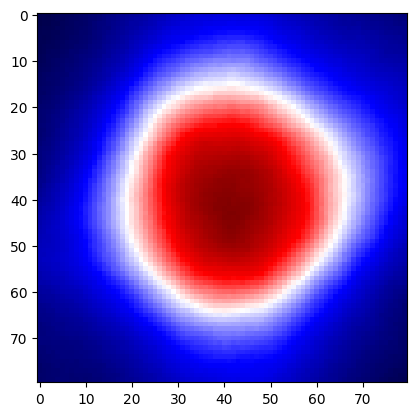

In [36]:
new_mean = cv2.normalize(Mean, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
plt.imshow(new_mean, cmap="seismic")
plt.show()

In [25]:
tif = str(section).zfill(3) + ".tif"
filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
input_file_virus_path = os.path.join(prep_path, 'C3/full_aligned', tif)  
input_file_dye_path = os.path.join(prep_path, 'C1/full_aligned', tif)  
data_virus = read_image(input_file_virus_path)
data_dye = read_image(input_file_dye_path)
print(f'{data_virus.shape=} {data_dye.shape=}')

data_virus.shape=(25000, 30000) data_dye.shape=(25000, 30000)


In [24]:
avg_cell_img_file_path = '/net/birdstore/Active_Atlas_Data/cell_segmentation/models/average_cell_image.pkl'
avg_cell_img = load(avg_cell_img_file_path) #Load average cell image once
avg_cell_CH1 = avg_cell_img['CH1']
avg_cell_CH3 = avg_cell_img['CH3']

print(avg_cell_CH1.shape)

(80, 80)


In [22]:
cell = 0
col = positives[cell][1]
row = positives[cell][0]
control_img = positives[cell][2]
section = 0
print(f'processing coordinates {col=}, {row=}, {section=}')
idx = 0

startc = col - 40
endc = startc + 80
startr = row - 40
endr = startr + 80

print(f'{startr=} {endr=} {startc=} {endc=}')

processing coordinates col=8734, row=23291, section=0
startr=23251 endr=23331 startc=8694 endc=8774


In [26]:
image_roi_virus = data_virus[startc:endc, startr:endr] #image_roi IS numpy array
image_roi_dye = data_dye[startc:endc, startr:endr] #image_roi IS numpy array
print(f'shape of image_roi_virus {image_roi_virus.shape} and shape of data_virus {image_roi_dye.shape}')
absolute_coordinates = (startc, endc, startr, endr)
difference_ch1 = subtract_blurred_image(image_roi_dye, make_smaller=False) #calculate img difference for virus channel (e.g. fluorescence)
difference_ch3 = subtract_blurred_image(image_roi_virus, make_smaller=False) #calculate img difference for virus channel (e.g. fluorescence)


shape of image_roi_virus (80, 80) and shape of data_virus (80, 80)


shape of data_dye (25000, 30000)
row=23291 col=8734 startr=23251 endr=23331 startc=8694 endc=8774


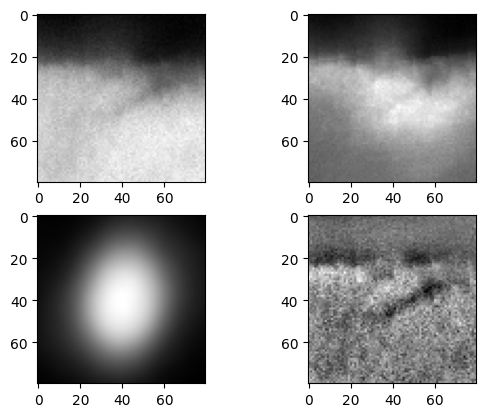

In [27]:
print(f'shape of data_dye {data_dye.shape}')
print(f'{row=} {col=} {startr=} {endr=} {startc=} {endc=}')
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(image_roi_dye, cmap="gray")
axarr[0,1].imshow(control_img, cmap="gray")
axarr[1,0].imshow(avg_cell_CH1, cmap="gray")
axarr[1,1].imshow(difference_ch1, cmap="gray")
